# 資料預處理

In [15]:
import sys
import os
 
root_dir = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
sys.path.insert(0, root_dir)

from probe_mark.dataset_Della.get_img import create_folders,get_img,make_folder,get_img_label,get_img_mask
# import sys
# import os
 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

In [ ]:
import pandas as pd
# from get_img import create_folders,get_img,make_folder,get_img_label,get_image

import os

from datetime import datetime
nowdir = os.getcwd()# 現在目錄
nowpath=root_dir+"\\data\\processed"
current_date = datetime.now()# 抓取現在的日期
formatted_date = current_date.strftime("%Y%m%d")# 格式化日期為所需格式

folder_path=make_folder(path=nowpath, folder_name='rowdata',date=formatted_date)


In [ ]:

folder_name = 'Artificial_VR22_D4070_MW120F-HS'
base_output_dir=make_folder(path=folder_path, folder_name=folder_name)
# 讀取 Excel 檔案中的特定 sheet
file_path = root_dir+'\\data\\raw\\'+folder_name+'\\picture.xlsx'
sheet_name = '主要'
# 讀取指定 sheet，並跳過第一行，同時指定新的欄位名稱
df = pd.read_excel(file_path, sheet_name=sheet_name, header=1, names=['name', 'img'])
img_name_list=df['name']  # 資料夾名稱列表
# filtered_list = [name for name in img_name_list if 'blank' not in name]
# 建立資料夾儲存圖片
created_folders = create_folders(base_output_dir, img_name_list)
get_img(file_path, sheet_name, created_folders,'original')

In [ ]:

# 讀取 Excel 檔案中的特定 sheet
sheet_name = '體積面積量測'
# # 建立資料夾儲存圖片
get_img(file_path, sheet_name, created_folders,'red_mark')


In [ ]:
# 使用範例
for i in range(len(created_folders)):
    image_path1 = created_folders[i] + '\\original.png'
    image_path2 = created_folders[i] + '\\red_mark.png'
    image_path3 = created_folders[i] + '\\mask.png'
    image_path4 = created_folders[i] + '\\label.png'
    get_img_mask(image_path1, image_path2, image_path3)
    get_img_label(image_path1, image_path2, image_path4)

# 資料訓練

In [1]:
folder_path=r'D:\github\Probe-Mark\data\processed\rowdata_20240813'

In [2]:
import os

def find_png(folder_path,img_name):
    img_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file == img_name:
                img_paths.append(os.path.join(root, file))
    return img_paths


label_paths = find_png(folder_path,"label.png")
orig_paths = find_png(folder_path,"original.png")

len(label_paths),len(orig_paths)

(234, 234)

### 拆分資料集

In [3]:
import os
from sklearn.model_selection import train_test_split
from collections import defaultdict

def group_paths_by_folder(paths):
    # 創建一個默認字典來存儲按第三層資料夾分類的路徑
    paths_by_folder = defaultdict(list)
    
    for path in paths:
        # 根據split取得第三層資料夾名稱
        folder_name = path.split(os.sep)[-3]
        paths_by_folder[folder_name].append(path)
    
    return paths_by_folder

def split_paths_by_folder_sklearn(paths, train_ratio=0.8):
    paths_by_folder = group_paths_by_folder(paths)
    
    # 初始化訓練集和測試集
    train_paths = []
    test_paths = []

    for folder, folder_paths in paths_by_folder.items():
        # 使用sklearn的train_test_split進行拆分
        train, test = train_test_split(folder_paths, train_size=train_ratio, random_state=42)
        train_paths.extend(train)
        test_paths.extend(test)
    
    return train_paths, test_paths

# 對label_paths進行拆分
train_label_paths, test_label_paths = split_paths_by_folder_sklearn(label_paths)

# 對orig_paths進行拆分
train_orig_paths, test_orig_paths = split_paths_by_folder_sklearn(orig_paths)

# 打印結果
i=49
print(train_label_paths[i],len(train_label_paths))
print(train_orig_paths[i],len(train_orig_paths))
print(test_label_paths[i],len(test_label_paths))
print(test_orig_paths[i],len(test_orig_paths))

D:\github\Probe-Mark\data\processed\rowdata_20240813\Artificial_VM_D80_MW120F-HS\25-OD75-1\label.png 184
D:\github\Probe-Mark\data\processed\rowdata_20240813\Artificial_VM_D80_MW120F-HS\25-OD75-1\original.png 184
D:\github\Probe-Mark\data\processed\rowdata_20240813\Artificial_VR29_D4070_thimble_5g\Die1-7-3-5g\label.png 50
D:\github\Probe-Mark\data\processed\rowdata_20240813\Artificial_VR29_D4070_thimble_5g\Die1-7-3-5g\original.png 50


### 準備數據集

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms.v2 as T
import torchvision.tv_tensors as tv_tensors
# 設置訓練的設備（GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 定義自訂義的資料集類別，用於語意分割任務
class SegmentationDataset(Dataset):
    def __init__(self, orig_paths, label_paths, transform=None):
        """
        初始化資料集類別。
        
        參數:
        - orig_paths: 原始影像的檔案路徑列表。
        - label_paths: 標籤影像的檔案路徑列表。
        - transform: 用於影像與標籤的轉換操作（如大小調整、格式轉換等）。
        """
        self.orig_paths = orig_paths # 儲存原始影像的路徑列表
        self.label_paths = label_paths # 儲存標籤影像的路徑列表
        self.transform = transform # 儲存轉換操作

    def __len__(self):
        """
        返回資料集的大小（即原始影像的數量）。
        """
        return len(self.orig_paths)

    def __getitem__(self, idx):
        """
        根據索引idx獲取對應的原始影像和標籤影像。
        
        參數:
        - idx: 索引值，用於提取對應的影像和標籤。
        
        返回:
        - orig_image: 經過轉換後的原始影像。
        - label_image: 經過轉換後的標籤影像。
        """
        orig_image = Image.open(self.orig_paths[idx]).convert("RGB") # 打開原始影像並將其轉換為RGB模式
        label_image = Image.open(self.label_paths[idx]).convert("L") # 打開標籤影像並將其轉換為單通道模式 (L mode)

        if self.transform:
            label_image = tv_tensors.Mask(label_image) # 將標籤影像轉換為Mask格式
            orig_image, label_image = self.transform(orig_image, label_image) # 同時轉換原始影像和標籤影像
        # 返回轉換後的原始影像和標籤影像
        # orig_image = (3,224,224) 為三通道（RGB）的影像
        # label_image = (1,224,224) 為單通道（灰階）的影像
        return orig_image, label_image

# 定義基本的影像轉換操作，將影像縮放到224x224，並轉換數據類型為float32和int64
BASIC_TRANSFORMS = T.Compose(
    [
        T.ToImage(),  # 將影像轉換為PIL格式或其他影像格式
        T.Resize(size=(224, 224)),  # 將影像縮放到224x224像素
        T.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,  # 原始影像轉換為浮點數格式
                tv_tensors.Mask: torch.int64,     # 標籤影像轉換為整數格式
                "others": None,                   # 其他類型不進行轉換
            },
            scale=True,  # 將影像像素值縮放到[0,1]區間
        )
    ]
)

# 創建資料集對象
dataset = SegmentationDataset(train_orig_paths, train_label_paths, transform=BASIC_TRANSFORMS)
dataloader=DataLoader(dataset, batch_size=4, shuffle=True)#包裝到DataLoader中，指定批次大小batch_size，且打亂順序

# dataset = SegmentationDataset(orig_paths, label_paths, transform=BASIC_TRANSFORMS) #通通拿來訓練
# dataset[0][1][0][100:120, 100:120]

In [6]:
# for epoch in range(1):
#     for orig_image, label_image in dataloader:
#         orig_image = orig_image.cuda()
#         label_image = label_image.cuda()

#         print(orig_image.device, label_image.device)
#         print(orig_image.shape, label_image.shape)


### 定義模型架構(VGG16)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [8]:
class VGG16(nn.Module):
    def __init__(self,classes=2):
        super().__init__()
        # 卷積層
        self.block_1=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block_2=nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block_3=nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.block_4=nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.block_5=nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # self.block_6=nn.Sequential(
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # # 全連接層
        # self.classifier=nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(512*7*7, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(),
        #     nn.Linear(4096,classes)
        # )
        # 上採樣層 (反卷積)
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # 輸出範圍在0到1
        )

    def forward(self, x):
        # 提取特徵
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        # x = self.block_6(x)
        # # # 展平進入全連接層(PCN不會用到)
        # # x = x.flatten(1)
        # # x = self.classifier(x)
        # # 不使用全連接層，直接進行上採樣
        x = self.upsample(x)
        return x


In [9]:
input_tensor = torch.randn(1, 3, 224, 224).to(device)
label_tensor = torch.randint(0, 1, (1, 1, 224, 224)).float().to(device)
model = VGG16(classes=2).cuda()
# model = UNet().to(device)

outputs=model(input_tensor)
print("input_tensor:",input_tensor.shape)
print("label_tensor:",label_tensor.shape)
print("outputs:",outputs.shape)

# 計算損失
criterion = nn.BCELoss().to(device)
loss = criterion(outputs, label_tensor)
print("loss:",loss.item())

input_tensor: torch.Size([1, 3, 224, 224])
label_tensor: torch.Size([1, 1, 224, 224])
outputs: torch.Size([1, 1, 224, 224])
loss: 0.6484200358390808


In [10]:
print(model) #打印出的模型結構是init不一定是forward

VGG16(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (block_3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (block_4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(256, 512, ker

### 定義模型架構(UNet)
https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        return self.pool(x), x  # 返回池化後的張量和卷積塊的輸出（用於跳躍連接）


In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat((x, skip), dim=1)  # 拼接（跳躍連接）
        return self.conv_block(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = Encoder(3, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)
        self.encoder4 = Encoder(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder4 = Decoder(1024, 512)
        self.decoder3 = Decoder(512, 256)
        self.decoder2 = Decoder(256, 128)
        self.decoder1 = Decoder(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 編碼過程
        x1, skip1 = self.encoder1(x)
        x2, skip2 = self.encoder2(x1)
        x3, skip3 = self.encoder3(x2)
        x4, skip4 = self.encoder4(x3)

        # 瓶頸層
        x5 = self.bottleneck(x4)

        # 解碼過程
        x = self.decoder4(x5, skip4)
        x = self.decoder3(x, skip3)
        x = self.decoder2(x, skip2)
        x = self.decoder1(x, skip1)
        x = self.final_conv(x)
        x = self.sigmoid(x)
        return x

### 訓練模型

In [11]:
import torch.optim as optim
import torch.nn as nn

# model = UNet()
model = VGG16()
model = model.to(device)  # 將模型移動到 GPU
print(model)


VGG16(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (block_3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (block_4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(256, 512, ker

In [12]:


# 定義損失函數和優化器
criterion = nn.BCELoss()  # 或者 nn.CrossEntropyLoss()多分類 根據你的需求
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # 訓練的回合數

model.train()  # 設置模型為訓練模式
loss_values = []# 初始化列表來記錄損失值
for epoch in range(num_epochs):
    running_loss = 0.0
    for orig_image, label_image in dataloader:
        orig_image = orig_image.to(device)
        label_image = label_image.to(device)

        optimizer.zero_grad()
        outputs = model(orig_image)

        # 計算損失
        loss = criterion(outputs, label_image.float())  # 確保標籤和輸出數據類型一致

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * orig_image.size(0)

    epoch_loss = running_loss / len(dataloader)
    loss_values.append(epoch_loss)  # 記錄損失值
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Finished Training")

Epoch 1/10, Loss: 1.7018
Epoch 2/10, Loss: 0.6546
Epoch 3/10, Loss: 0.3694
Epoch 4/10, Loss: 0.2239
Epoch 5/10, Loss: 0.1481
Epoch 6/10, Loss: 0.1097
Epoch 7/10, Loss: 0.0990
Epoch 8/10, Loss: 0.0960
Epoch 9/10, Loss: 0.1005
Epoch 10/10, Loss: 0.0787
Finished Training


In [16]:
root_dir = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
save_path=root_dir+"\\runs"

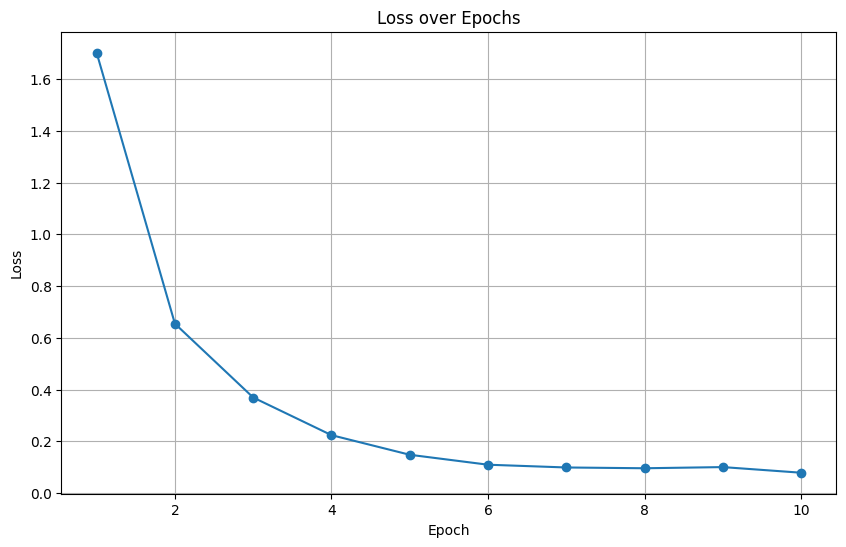

In [17]:
import matplotlib.pyplot as plt

# 繪製損失曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)

# 保存圖像，指定文件名稱和格式
# plt.savefig(save_path+'\\UNet_loss_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(save_path+'\\VGG16_loss_curve.png', dpi=300, bbox_inches='tight')
# 顯示圖像
plt.show()


### 儲存模型

In [19]:
import torch

# 保存模型的狀態字典
# torch.save(model.state_dict(), save_path+'\\unet_model.pth')
torch.save(model.state_dict(), save_path+'\\vgg16_model.pth')
# 保存完整模型
# torch.save(model, save_path+'\\unet_full_model.pth')
torch.save(model, save_path+'\\vgg16_full_model.pth')



### 加載模型

In [20]:
import torch
import torch.nn as nn

# 初始化模型
# model = UNet()
model = VGG16()

# 加載模型的狀態字典
# model.load_state_dict(torch.load(save_path+'\\unet_model.pth'))
model.load_state_dict(torch.load(save_path+'\\vgg16_model.pth'))
# 加載完整模型
# model = torch.load(save_path+'\\unet_full_model.pth')
model = torch.load(save_path+'\\vgg16_full_model.pth')

C:\Users\User\AppData\Local\Temp\ipykernel_22616\3478088987.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path+'\\vgg16_model.pt

# 模型推論

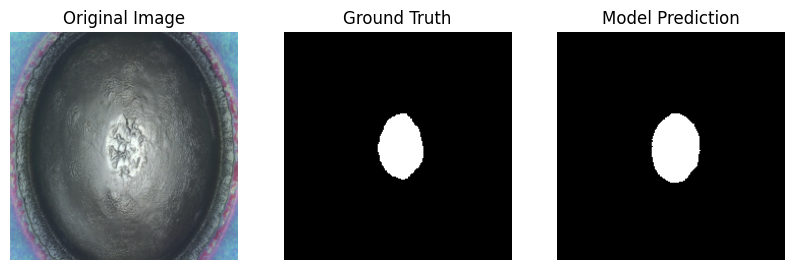

In [35]:
import matplotlib.pyplot as plt

# 創建測試集的資料集和數據加載器
test_dataset = SegmentationDataset(test_orig_paths, test_label_paths, transform=BASIC_TRANSFORMS)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 將模型設置為評估模式（這在進行推理時是必要的）
model.eval()
with torch.no_grad():
    for orig_image, label_image in dataloader:
        orig_image = orig_image.to(device)
        label_image = label_image.to(device)

        outputs = model(orig_image) 
        # 將輸出轉換0或1
        outputs = (outputs > 0.5).float()

        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(orig_image[0].permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(label_image[0][0].cpu().numpy(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(outputs[0][0].cpu().numpy(), cmap="gray")
        plt.title("Model Prediction")
        plt.axis("off")

        # 保存圖像，指定文件名稱和格式
        # plt.savefig(save_path+'\\UNet_image_test.png', dpi=300, bbox_inches='tight')
        plt.savefig(save_path+'\\VGG16_image_test.png', dpi=300, bbox_inches='tight')
        plt.show()
        break

### IoU (Intersection over Union)
衡量模型預測的區域和真實區域的重疊部分佔所有區域的比例

In [43]:
# for orig_image, label_image in test_dataloader:
#     orig_image = orig_image.to(device)  # 將輸入張量移動到 GPU
#     label_image = label_image.to(device)  # 如果需要，也將標籤移動到 GPU
#     outputs = model(orig_image)  # outputs 應該是形狀為 (N, C, H, W)
#     print(orig_image.shape)
#     print(label_image.shape)
#     print(outputs.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4,

Batch IoU: 0.4790
Batch IoU: 0.4742
Batch IoU: 0.4820
Batch IoU: 0.4727
Batch IoU: 0.4791
Batch IoU: 0.4769
Batch IoU: 0.4720
Batch IoU: 0.4808
Batch IoU: 0.4729
Batch IoU: 0.4714
Batch IoU: 0.4213
Batch IoU: 0.4878
Batch IoU: 0.4617
Mean IoU on test set: 0.4717


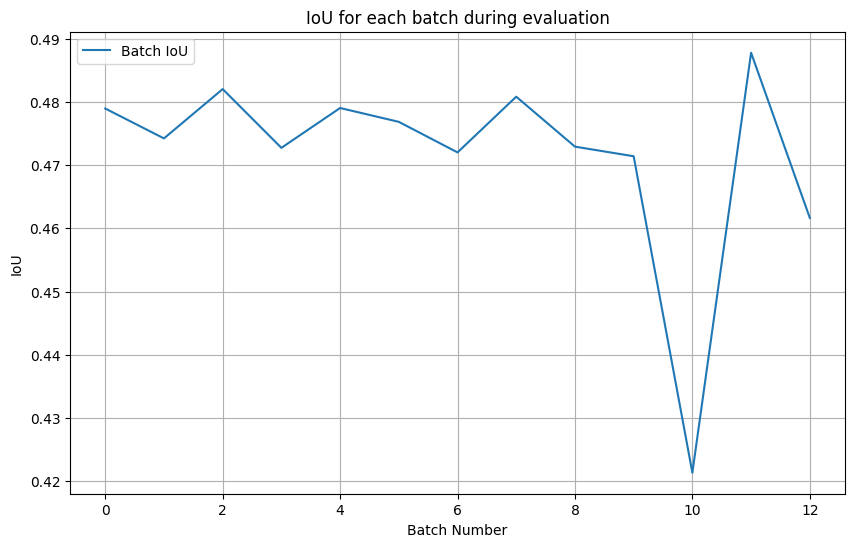

In [46]:
import torchmetrics
import matplotlib.pyplot as plt

# 創建測試集的資料集和數據加載器
test_dataset = SegmentationDataset(test_orig_paths, test_label_paths, transform=BASIC_TRANSFORMS)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

model.eval()  # 切換模型為評估模式

# 初始化IoU指標，指定task為'multiclass'
iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=2).to(device)

# 初始化變量來計算總的IoU和記錄每個batch的IoU
total_iou = 0.0
total_batches = 0
batch_iou_values = []  # 用於存儲每個batch的IoU

# 在測試集上進行評估
with torch.no_grad():  # 在評估模式下禁用梯度計算
    for orig_image, label_image in test_dataloader:
        orig_image = orig_image.to(device)
        label_image = label_image.to(device)

        # 模型預測
        outputs = model(orig_image)  # outputs 應該是形狀為 (N, C, H, W)
        preds = torch.argmax(outputs, dim=1)  # 獲取預測結果，形狀為 (N, H, W)

        # 確保label_image的形狀是 (N, H, W)
        label_image = label_image.squeeze(1)  # 如果label_image是 (N, 1, H, W)，可以使用squeeze去掉1維度

        # 計算這個batch的IoU
        batch_iou = iou_metric(preds, label_image)
        print(f"Batch IoU: {batch_iou.item():.4f}")
        total_iou += batch_iou.item()
        total_batches += 1

        # 記錄每個batch的IoU
        batch_iou_values.append(batch_iou.item())

# 計算平均IoU
mean_iou = total_iou / total_batches
print(f"Mean IoU on test set: {mean_iou:.4f}")

# 繪製每個batch的IoU圖
plt.figure(figsize=(10, 6))
plt.plot(batch_iou_values, label='Batch IoU')
plt.xlabel('Batch Number')
plt.ylabel('IoU')
plt.title('IoU for each batch during evaluation')
plt.legend()
plt.grid(True)
plt.savefig(save_path+'\\VGG16_IoU.png')
plt.show()


### Dice coefficient (Dice score)
又稱F1-score，適合於二分類或少量類別的語義分割問題